In [ ]:
## EBAS Database

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from streamlit_folium import folium_static
import folium
from branca.colormap import linear, LinearColormap

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import TwoByTwoLayout 

In [3]:
# import project moduel
from ebas_importer import *
from ebas_proj import *
import utilities

### 1. Create Database
#### 1.1 Fetch data from ftp

In [4]:
# class handle data download, update, create ebas database files
ebas_data = EbasData(data_path = r"C:\Users\zhouc\Desktop\GitHub\ebas\raw_data", # path store the raw data file
                file_type="nc",   # need to support .nas file 
                compression=None) # can also be 'xz', if used, the database will be reduced to ~800MB

In [5]:
# check updates for local raw data 
ebas_data.check_updates(download=True,   # file will be download if download = True
                       print_file=False) # control whether print file names

----------------------------------------------------------------------------------------------------
Check for updates...
12974 raw data files in current data directory.
Reqesting data from ftp...
12974 files on ftp server.


check local files...: 100%|██████████| 12975/12975 [00:00<00:00, 14598.92it/s]

0 files need to be added.
0 files need to be archived.
Data is written to errors.csv.
----------------------------------------------------------------------------------------------------


#### 1.2. Summary site information

In [6]:
# All the information of .nc file will be recorded if detailed set as True.
ebas_data.data_importer.detailed = False

# gather information for each site, and dump to file as database indexing file:
# 1. site geographcial information
# 2. how many files, components measured for this site
# value index must be created before it can be used.
ebas_data.get_site_infor(exporting = "xz",      # if None: export as .json
                         use_value_index = False # if True: use number to replace string values of some attributes.
                        )

# value index will be created for site, component, matrix, unit, resolution
# use value index will largely decrease database size
# "value_index" file will be generated for feature usage
ebas_data.create_value_index()

# update site information with value index
ebas_data.get_site_infor(use_value_index=True)

----------------------------------------------------------------------------------------------------
Gathering site information...


100%|██████████| 12974/12974 [01:46<00:00, 121.48it/s]


site number : 882
Dumping data to disk...
Data is written to 'site_infor.xz'.
creating value index...
----------------------------------------------------------------------------------------------------
Gathering site information...


100%|██████████| 12974/12974 [01:42<00:00, 127.12it/s]


site number : 882
Dumping data to disk...
Data is written to 'site_infor.xz'.


#### 1.3. Generate database files

In [7]:
# create data file for each site
# those files will be loaded when database runs
ebas_data.import_site_data()

Importing datafile of each site...


100%|██████████| 882/882 [01:32<00:00,  9.51it/s]


### 2. Run Database  
#### 2.1 Database config

In [8]:
# run database with configs
# about 20s to load all datafiles
ebas = EbasDataBase(site_infor_path="site_infor.xz", # this file is generated in 1.2 
                    data_path="ebas_proj_dump",      # path stores data files generated in 1.3 
                    lazy_loading=False,              # if True, datafile will only be loaded when necessary
                    compression=None                 # can be 'xz', should be consistent with 1.1
                   )

init database...
	882 files in the data path ebas_proj_dump.
	None compression method is used in for the data file.
load site information...
load all ebas data files...


100%|██████████| 882/882 [00:20<00:00, 43.75it/s]


gathering database summary...
882        sites included in current database.
677        components included in current database.
32         matrix included in current database.
72         country included in current database.
Current database ranges from 1971-01-01 to 2021-10-05.


#### 2.2 Query from database

In [9]:
# config a search with dict
search_dict={
    "component":["nitrate", "nitric_acid"],
    "matrix":["air", "aerosol"],
    "stat":['arithmetic mean',"median"],
    "st":np.datetime64("1970-01-01"),
    "ed":np.datetime64("2021-10-01"),
    
    # other configs:
    # "id":["AM0001R"]
    # "country":["Denmark","France"],
}

# search result will be a pandas DataFrame
# note: val is already selected by qc flag.
ebas.select_db(search_dict)
res_df = ebas.get_selected_db(use_number_index=False) # if use_number_index is True, all the values will be value index.

seraching...: 100%|██████████| 882/882 [00:00<00:00, 17624.81it/s]


Loading necessary data...


0it [00:00, ?it/s]


Gathering data to dataframe...


100%|██████████| 128/128 [00:00<00:00, 1705.20it/s]


In [10]:
print(res_df.shape)
res_df.head()

(829114, 7)


,st,ed,val,site,component,unit,matrix
0,2009-01-01 03:00:00,2009-01-02 03:00:00,0.026,AM0001R,nitrate,ug N/m3,aerosol
1,2009-01-02 03:00:00,2009-01-03 03:00:00,NaN,AM0001R,nitrate,ug N/m3,aerosol
2,2009-01-03 03:00:00,2009-01-04 03:00:00,0.015,AM0001R,nitrate,ug N/m3,aerosol
3,2009-01-04 03:00:00,2009-01-05 03:00:00,0.008,AM0001R,nitrate,ug N/m3,aerosol
4,2009-01-05 03:00:00,2009-01-06 03:00:00,0.028,AM0001R,nitrate,ug N/m3,aerosol


#### 2.3 Simple UI

In [11]:
combox1 = widgets.SelectMultiple(
    options= ebas.summary["components"],
    value=["nitrate"],
    description='components:',
    disabled=False,
)

combox2 = widgets.SelectMultiple(
    options= ebas.summary["matrix"],
    value=[ebas.summary["matrix"][0]],
    description='matrix:',
    disabled=False,
)

combox3 = widgets.Dropdown(
    options= list(range(1970,2023)),
    value=2018,
    description='starting date:',
    disabled=False,
)

combox4 = widgets.Dropdown(
    options= list(range(1970,2023)),
    value=2021,
    description='ending date:',
    disabled=False,
)

output = widgets.Output()


In [12]:
global res_df 
def on_button_clicked(b):
    global res_df 
    with output:
        clear_output()
        search_dict={
           "component":combox1.value,
           "matrix":combox2.value,
           "stat":['arithmetic mean',"median"],
           "st":np.datetime64(str(combox3.value)),
           "ed":np.datetime64(str(combox4.value)),
        }
        ebas.select_db(search_dict)
        res_df = ebas.get_selected_db(use_number_index=False)
        print(res_df.shape)
        print(res_df.head())

In [13]:
layout = TwoByTwoLayout(top_left=combox1,
               top_right=combox2,
               bottom_left=combox3,
               bottom_right=combox4)
        
button = widgets.Button(description="search")
button.on_click(on_button_clicked)

display(layout,button, output)

TwoByTwoLayout(children=(SelectMultiple(description='components:', index=(535,), layout=Layout(grid_area='top-…

Button(description='search', style=ButtonStyle())

Output()

#### 2.4 Visualization

CH0001G 99999.0


C:\Users\zhouc\AppData\Local\Temp/ipykernel_1083584/3373507422.py:10: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(y)<1000:
C:\Users\zhouc\AppData\Local\Temp/ipykernel_1083584/3373507422.py:13: RuntimeWarning: All-NaN axis encountered
  print(s, np.nanmax(y))


ES0001R nan
ES0003R nan
ES0004R nan
ES0005R nan
ES0006R nan


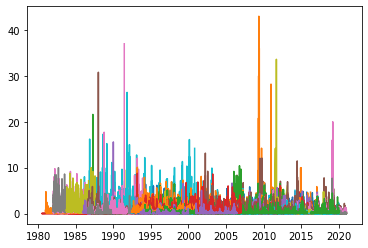

In [14]:
# plot time series
sites = res_df["site"].unique()
for s in sites:
    temp = res_df[res_df["site"]==s]
    temp = temp[temp["component"]==combox1.value[0]]
    temp = temp[temp["matrix"]==combox2.value[0]]
    x = temp["st"]
    y = temp["val"]
    if len(y)>0:
        if np.nanmax(y)<1000:
            plt.plot(x,y,'-')
        else:
            print(s, np.nanmax(y))
plt.show()

In [15]:
site_data = {}
max_val = -999
for s in sites:
    temp = res_df[res_df["site"]==s]
    
    vals = temp[temp["component"]==combox1.value[0]]
    vals = vals[vals["matrix"]==combox2.value[0]]
    
#     print(nitric_acid_air["val"].mean(skipna=True))
    
    site_data[s] ={
        "lat": ebas.site_infor[s]["lat"],
        "lon": ebas.site_infor[s]["lon"],
        "name": ebas.site_infor[s]["name"],
        "vals": vals["val"].mean(skipna=True),
    }
    if vals["val"].mean(skipna=True) > max_val:
        max_val = vals["val"].mean(skipna=True)

In [16]:
# interactive map
main_map = folium.Map(location=(55, 0), zoom_start=3, color="grey")
folium.TileLayer('cartodbpositron').add_to(main_map)

colormap = linear.YlOrRd_06.scale(0,max_val)

# den_colormap = colormap.colors
# den_colormap.reverse()

# colormap = LinearColormap(colors=den_colormap)

colormap.add_to(main_map)
for site in site_data.keys():
    content =site_data[site]
    icon_color = "black" if np.isnan(content["vals"]) else colormap(content["vals"])
    # city_graph = city_graphs['for_map'][city.station_id][field_to_color_by]
    try:
        lat = float(content["lat"])
        lon = float(content["lon"])
    except:
        continue
    if not np.isnan(lat):
        folium.CircleMarker(location=[float(content["lat"]), float(content["lon"])],
                        tooltip=f"{content['name']}: {combox1.value[0]} = {np.round(content['vals'],3)}",
                        fill=True,
                        fill_color=icon_color,
                        color=None,
                        fill_opacity=1,
                        radius= 0.01 if np.isnan(content["vals"]) else 5
                        #     popup = folium.Popup().add_child(
                        #                             folium.features.VegaLite(city_graph)
                        #                             )
                        ).add_to(main_map)


main_map